# Transitland Datastore Issue [#352](https://github.com/transitland/transitland-datastore/issues/352):

https://github.com/transitland/station-hierarchy-exploratory-analysis

Many `Station`/`StationPlatform`/`StationEntrance` and `Route` models in Transitland are also in OpenStreetMap. We currently conflate `Stop`s (soon to be `StationEntrance`s #256) with the nearest pedestrian way in OSM (using Valhalla). But we don't yet have any way to match a station polygon in OSM to the same station in Transitland, or to connect route geometries. This would be useful for analysis applications, as well as to remove duplicates when building vector tiles using both OSM and Transitland data (#351).

One potential approach:
1. Put a Onestop ID on feature(s) in OSM. For example: http://www.openstreetmap.org/way/77411120
2. In the Datastore, regularly use [Overpass API](https://github.com/BrunoSalerno/overpass-api-ruby) to query for features that have Onestop ID tags. Store (and regularly update) those OSM feature IDs in Transitland `Station` and `Route` models.

To do that at scale might require an editing UI or an addition to the iD OSM editor.

# References

http://wiki.openstreetmap.org/wiki/Public_transport

http://wiki.openstreetmap.org/wiki/Proposed_features/Public_Transport

http://wiki.openstreetmap.org/wiki/Railway_stations

https://overpass-turbo.eu/#

https://transit.land/api/v1/stops/s-9q8vzhbf8h-millbrae

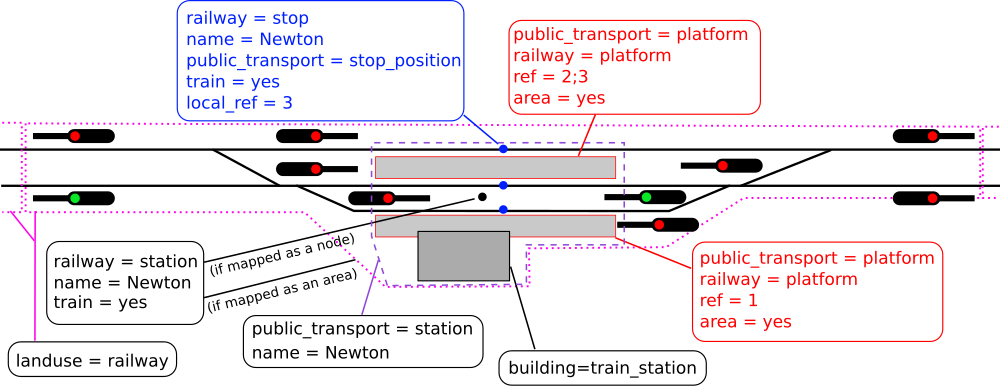

In [1]:
from IPython.display import Image
Image("http://wiki.openstreetmap.org/w/images/thumb/8/83/A-simple-station.svg/1000px-A-simple-station.svg.png")

# Which OpenStreetMap Tags to Use?

### Station tags:

    way["railway"="station"]{0};
    way["public_transport"="station"]{0};
    way["building"="train_station"]{0};

    node["railway"="station"]["usage" != "tourism"]{0};
    node["public_transport"="station"]{0};
    node["building"="train_station"]["train"="yes"]{0}; 


Keep in mind, but don't use:

    relation["public_transport"="stop_area"];
    way["landuse"="railway"];
    
You can see that we exclude usage = tourism for nodes with railway = station to exclude tourist railways (i.e. the miniature steam train at the San Francisco zoo).

### Egress tags:

    node["railway" = "subway_entrance"]
    way["railway" = "subway_entrance"]

### Platform tags:

- way["railway" = "platform"]
- way["public_transport" = "platform"]

- node["railway" = "platform"]
- node["public_transport" = "platform"]

### Bus stop tags:

- way["highway" = "bus_stop"]
- node["highway" = "bus_stop"]

# Helper functions

Convert Overpass API JSON response to GeoJSON.

In [2]:
from geojson import FeatureCollection, Feature, Polygon, Point

In [3]:
def overpass2geojson(data):
    
    ways = [i for i in data['elements'] if i['type'] == 'way']
    nodes = [i for i in data['elements'] if i['type'] == 'node']
    pois = [i for i in nodes if 'tags' in i.keys()]
    
    print len(ways) + len(pois), "points of interest returned."
    print len(ways), "as ways and", len(pois), "as nodes."
    
    # Create indexes for lookups by way_id and node_id
    lookup_wayid = {}
    lookup_nodeid = {}
    lookup_pois_nodeid = {} # POIs are nodes with tags
        
    # Populate indexes with info
    for i in nodes:
        lookup_nodeid[i['id']] = [i['lon'], i['lat']]
    
    for i in pois:
        lookup_pois_nodeid[i['id']] = i
        lookup_pois_nodeid[i['id']]["coordinates"] = lookup_nodeid[i['id']]
        lookup_pois_nodeid[i["id"]]["properties"] = i["tags"]
        lookup_pois_nodeid[i["id"]]["properties"]["id"] = i["id"]
        lookup_pois_nodeid[i["id"]]["properties"]["type"] = "node"
        lookup_pois_nodeid[i["id"]]["properties"]["@id"] = "node" + "/" + str(i["id"])
        
    for i in ways:
        lookup_wayid[i['id']] = i
        lookup_wayid[i['id']]["coordinates"] = [[lookup_nodeid[j] for j in i['nodes']]]
        lookup_wayid[i["id"]]["properties"] = lookup_wayid[i["id"]]["tags"]
        lookup_wayid[i["id"]]["properties"]["id"] = i["id"]
        lookup_wayid[i["id"]]["properties"]["type"] = "way"
        lookup_wayid[i["id"]]["properties"]["@id"] = "way" + "/" + str(i["id"])
    
    features = []
    # Append ways to features
    for i in lookup_wayid.keys():
        polygon = Polygon(lookup_wayid[i]['coordinates'])
        props = lookup_wayid[i]['properties']
        feature = Feature(geometry=polygon, properties=props)
        features.append(feature)
        
    # Append POI nodes to features
    for i in lookup_pois_nodeid.keys():
        point = Point(lookup_pois_nodeid[i]['coordinates'])
        props = lookup_pois_nodeid[i]['tags']
        feature = Feature(geometry=point, properties=props)
        features.append(feature)
        
    featureCollection = FeatureCollection(features)
    
    return featureCollection

Map GeoJSON with Leaflet (via Folium).

In [4]:
import folium

In [5]:
def geojson2leaflet(overpass_geojson, zoom_start=11, tiles="OpenStreetMap"):
        
    try: # average of first and last coordinate
        centerLat = (overpass_geojson['features'][0]['geometry']['coordinates'][0][0][1] + overpass_geojson['features'][0]['geometry']['coordinates'][0][-1][1]) / 2
        centerLon = (overpass_geojson['features'][0]['geometry']['coordinates'][0][0][0] + overpass_geojson['features'][0]['geometry']['coordinates'][0][-1][0]) / 2
    except:
        centerLat = overpass_geojson['features'][0]['geometry']['coordinates'][1]
        centerLon = overpass_geojson['features'][0]['geometry']['coordinates'][0]
    
    m = folium.Map(location=[centerLat, centerLon], zoom_start=zoom_start, tiles=tiles)        
    gj = folium.GeoJson(overpass_geojson)
    gj.add_to(m)

    return m

# Define bbox

Use [bboxfinder](http://bboxfinder.com/#37.665070,-122.598983,37.861302,-122.211227).

In [260]:
bay_area_bbox = "-122.598983,37.665070,-122.211227,37.861302"

Format bbox to conform to Overpass API:

In [271]:
west, south, east, north = bay_area_bbox.split(",")
bbox = str("(" + south + ", " + west + ", " + north + ", " + east + ")")

# Get all stations within bbox

[Overpass Stations Query](http://overpass-turbo.eu/s/qnC)

In [6]:
import requests
import urllib

In [275]:
def get_stations_in_bbox(bbox):
    """Returns station ways and nodes within bounding box"""
    
    base_url = "https://overpass-api.de/api/interpreter?data="

    query = """
    [out:json][timeout:500];

    (
      way["railway"="station"]{0};
      way["public_transport"="station"]{0};
      way["building"="train_station"]{0};
      
      node["railway"="station"]["usage" != "tourism"]{0};
      node["public_transport"="station"]{0};
      node["building"="train_station"]["train"="yes"]{0}; 
    );

    out body;
    >;
    out skel qt;
    """.format(bbox)
    
    query_htmlified = urllib.quote(query.strip())
    api_request = base_url + query_htmlified
    response = requests.get(api_request)
    data = response.json()
    geojson = overpass2geojson(data)
    
    return geojson

In [276]:
stations_in_bbox = get_stations_in_bbox(bbox)

34 points of interest returned.
14 as ways and 20 as nodes.


In [274]:
geojson2leaflet(stations_in_bbox)

# Get all stations near lat/lon

In [13]:
def get_stations_near_latlon(lat=0, lon=0, radius=50):
    base_url = "https://overpass-api.de/api/interpreter?data="

    query = """
    [out:json][timeout:500];

    (
      // Get ways
      way(around:{0}, {1}, {2})["railway"="station"];
      way(around:{0}, {1}, {2})["public_transport"="train_station"];
      way(around:{0}, {1}, {2})["building"="train_station"];
      
      // Get nodes
      node(around:{0}, {1}, {2})["railway"="station"]["usage" != "tourism"];
      node(around:{0}, {1}, {2})["public_transport"="train_station"];
      node(around:{0}, {1}, {2})["building"="train_station"];
    );

    out body;
    >;
    out skel qt;
    """.format(radius, lat, lon)

    query_htmlified = urllib.quote(query.strip())
    api_request = base_url + query_htmlified
    response = requests.get(api_request)
    data = response.json()
    geojson = overpass2geojson(data)
    
    return geojson

In [14]:
stations_near_latlon = get_stations_near_latlon(lat=37.600271, lon=-122.386702)

2 points of interest returned.
1 as ways and 1 as nodes.


In [15]:
geojson2leaflet(stations_near_latlon, zoom_start=17)

# Get all egresses in bbox

[Overpass Egresses Query](http://overpass-turbo.eu/s/qnE)

In [277]:
def get_egresses_in_bbox(bbox):
    base_url = "https://overpass-api.de/api/interpreter?data="

    query = """
    [out:json][timeout:500];

    (
      way["railway"="subway_entrance"]{0};
      node["railway"="subway_entrance"]{0};
    );

    out body;
    >;
    out skel qt;
    """.format(bbox)

    query_htmlified = urllib.quote(query.strip())
    api_request = base_url + query_htmlified
    response = requests.get(api_request)
    data = response.json()
    geojson = overpass2geojson(data)
    
    return geojson

In [278]:
egresses_in_bbox = get_egresses_in_bbox(bbox)

82 points of interest returned.
1 as ways and 81 as nodes.


In [279]:
geojson2leaflet(egresses_in_bbox)

# Get all egresses near lat/lon

In [280]:
def get_subway_entrances_near_latlon(lat=0, lon=0, radius=50):
    base_url = "https://overpass-api.de/api/interpreter?data="

    query = """
    [out:json][timeout:500];

    (
      way(around:{0}, {1}, {2})["railway"="subway_entrance"];
      node(around:{0}, {1}, {2})["railway"="subway_entrance"];
    );

    out body;
    >;
    out skel qt;
    """.format(radius, lat, lon)

    query_htmlified = urllib.quote(query.strip())
    api_request = base_url + query_htmlified
    response = requests.get(api_request)
    data = response.json()
    geojson = overpass2geojson(data)
    
    return geojson

In [281]:
subway_entrances_near_latlon = get_subway_entrances_near_latlon(lat=37.789403, lon=-122.401080)

2 points of interest returned.
0 as ways and 2 as nodes.


In [282]:
geojson2leaflet(subway_entrances_near_latlon, zoom_start=18)

# Get all platforms within bbox

[Overpass Platforms Query](http://overpass-turbo.eu/s/qnF)

In [283]:
def get_platforms_in_bbox(bbox):
    """Returns station ways and nodes within bounding box"""
    
    base_url = "https://overpass-api.de/api/interpreter?data="

    query = """
    [out:json][timeout:500];

    (
      way["railway"="platform"]{0};
      way["public_transport"="platform"]{0};
      
      node["railway"="platform"]{0};
      node["public_transport"="platform"]{0};
    );

    out body;
    >;
    out skel qt;
    """.format(bbox)

    query_htmlified = urllib.quote(query.strip())
    api_request = base_url + query_htmlified
    response = requests.get(api_request)
    data = response.json()
    geojson = overpass2geojson(data)
    
    return geojson

In [337]:
platforms_in_bbox = get_platforms_in_bbox(bbox)

196 points of interest returned.
133 as ways and 63 as nodes.


In [338]:
geojson2leaflet(platforms_in_bbox)

# Get all platforms near lat/lon

In [341]:
def get_platforms_near_latlon(lat=0, lon=0, radius=50):
    base_url = "https://overpass-api.de/api/interpreter?data="

    query = """
    [out:json][timeout:500];

    (
      way(around:{0}, {1}, {2})["railway"="platform"];
      way(around:{0}, {1}, {2})["public_transport"="platform"];
      node(around:{0}, {1}, {2})["railway"="platform"];
      node(around:{0}, {1}, {2})["public_transport"="platform"];
    );

    out body;
    >;
    out skel qt;
    """.format(radius, lat, lon)
    
    query_htmlified = urllib.quote(query.strip())
    api_request = base_url + query_htmlified
    response = requests.get(api_request)
    data = response.json()
    geojson = overpass2geojson(data)
    
    return geojson

In [342]:
platforms_near_latlon = get_platforms_near_latlon(lat=37.600271, lon=-122.386702)

5 points of interest returned.
5 as ways and 0 as nodes.


In [343]:
geojson2leaflet(platforms_near_latlon, zoom_start=18)

# Get all bus stops in bounding box

[Overpass Bus Stops Query](http://overpass-turbo.eu/s/qnG)

In [292]:
def get_bus_stops_in_bbox(bbox):
    """Returns bus stop ways and nodes within bounding box"""
    
    base_url = "https://overpass-api.de/api/interpreter?data="

    query = """
    [out:json][timeout:500];

    (
      way["highway"="bus_stop"]{0};      
      node["highway"="bus_stop"]{0};
    );

    out body;
    >;
    out skel qt;
    """.format(bbox)

    query_htmlified = urllib.quote(query.strip())
    api_request = base_url + query_htmlified
    response = requests.get(api_request)
    data = response.json()
    geojson = overpass2geojson(data)
    
    return geojson

In [339]:
bus_stops_in_bbox = get_bus_stops_in_bbox(bbox)

1241 points of interest returned.
0 as ways and 1241 as nodes.


# Get all bus stops near lat/lon

In [295]:
def get_bus_stops_near_latlon(lat=0, lon=0, radius=50):
    base_url = "https://overpass-api.de/api/interpreter?data="

    query = """
    [out:json][timeout:500];

    (
      way(around:{0}, {1}, {2})["highway"="bus_stop"];
      node(around:{0}, {1}, {2})["highway"="bus_stop"];
    );

    out body;
    >;
    out skel qt;
    """.format(radius, lat, lon)
    
    query_htmlified = urllib.quote(query.strip())
    api_request = base_url + query_htmlified
    response = requests.get(api_request)
    data = response.json()
    geojson = overpass2geojson(data)
    
    return geojson

In [296]:
bus_stops_near_latlon = get_bus_stops_near_latlon(lat=37.804872, lon=-122.29514, radius=100)

1 points of interest returned.
0 as ways and 1 as nodes.


In [297]:
geojson2leaflet(bus_stops_near_latlon, zoom_start=18)

# West Oakland Example

    ### STATION ###
    Name: WEST OAKLAND BART STATION 
    Operators: Alameda-Contra Costa Transit District 
    Type: Station 
    Vehicles: bus 
    Location: [-122.294742, 37.804795] 
    Onestop-id: s-9q9p145svu-westoaklandbartstation
    
    ### STOP ###
    Name: West Oakland 
    Operators: Bay Area Rapid Transit 
    Type: Simple Stop 
    Vehicles: metro 
    Location: [-122.29514, 37.804872] 
    Onestop-id: s-9q9p145u1w-westoakland

Are there any platforms within 5 meters from the supposed stop?

In [298]:
platforms_near_latlon = get_platforms_near_latlon(lat=37.804872, lon=-122.29514, radius=5)

1 points of interest returned.
1 as ways and 0 as nodes.


In [299]:
geojson2leaflet(platforms_near_latlon, zoom_start=18)

# Analyze OSM Station tags

In [59]:
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [300]:
stations_in_bbox = get_stations_in_bbox(bbox)
geojson2leaflet(stations_in_bbox)

34 points of interest returned.
14 as ways and 20 as nodes.


### Count Station Tag Keys

In [301]:
def tag_key_counter(geojson):

    ways = [i for i in geojson['features'] if i['properties']['type'] == 'way']
    nodes = [i for i in geojson['features'] if i['properties']['type'] == 'node']

    ways_and_nodes = ways + nodes
    
    print len(ways_and_nodes), "total records."
    print len(ways), "as ways,", len(nodes), "as nodes"
    
    tag_key_counts = defaultdict(lambda: 0)

    for i in ways_and_nodes:
        tags = i['properties'].keys()
        for tag in tags:
            if i['properties'][tag] not in ({}, [], ()): # ignore empty containers
                tag_key_counts[tag] += 1            
    return tag_key_counts

In [302]:
station_key_counts = tag_key_counter(stations_in_bbox)

34 total records.
14 as ways, 20 as nodes


In [303]:
def get_most_popular_tag_keys(tag_key_counts):
    most_popular_tag_keys = pd.DataFrame(tag_key_counts.values(), tag_key_counts.keys()).sort_values(by=0, ascending = False)
    most_popular_tag_keys.columns=['Count']
    most_popular_tag_keys['Percent'] = most_popular_tag_keys['Count'] / tag_key_counts['id'] * 100
    return most_popular_tag_keys

In [304]:
most_popular_station_keys = get_most_popular_tag_keys(station_key_counts)
most_popular_station_keys.head(20)

,Count,Percent
@id,34,100.000000
id,34,100.000000
type,34,100.000000
name,33,97.058824
railway,31,91.176471
operator,25,73.529412
public_transport,22,64.705882
wikipedia,20,58.823529
train,19,55.882353
wikidata,19,55.882353


In [305]:
def plot_most_popular_tag_keys(most_popular_tag_keys, title):    
    most_popular_tag_keys_reverse = most_popular_tag_keys.sort_values(by='Count', ascending=True) # for plot
    ax = most_popular_tag_keys_reverse[['Percent']].plot(kind='barh', figsize=(10,12), title=title);
    for p in ax.patches:
        ax.annotate("%.0f%%" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 0), textcoords='offset points')

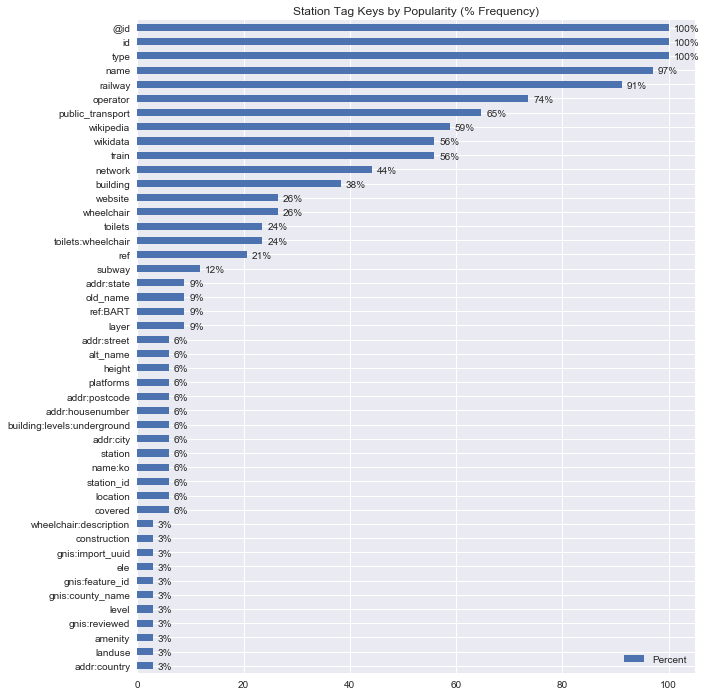

In [306]:
plot_most_popular_tag_keys(most_popular_station_keys, title="Station Tag Keys by Popularity (% Frequency)")

### Get All OSM Tag Key-Value Pairs

In [307]:
def get_tag_key_value_pairs(geojson):

    ways = [i for i in geojson['features'] if i['properties']['type'] == 'way']
    nodes = [i for i in geojson['features'] if i['properties']['type'] == 'node']

    ways_and_nodes = ways + nodes
    
    tag_key_value_pairs = defaultdict(lambda: [])

    for i in ways_and_nodes:
        keys = i['properties'].keys()
        for key in keys:
            if i['properties'][key] not in ({}, [], ()): # ignore empty containers
                tag_key_value_pairs[key].append(i['properties'][key])           
    
    return tag_key_value_pairs

In [308]:
station_key_value_pairs = get_tag_key_value_pairs(stations_in_bbox)

Make a dataframe out of key-value pairs.

In [309]:
pd.set_option('display.max_columns', 500)

In [310]:
def make_key_value_df(key_value_pairs, geojson, most_popular_tag_keys):
    key_value_df = pd.DataFrame(index=key_value_pairs.keys(), columns=key_value_pairs['name'])
    key_value_df = key_value_df.fillna('')

    for station_name in key_value_df.columns:
        for i in geojson['features']:
            if 'name' in i['properties'].keys():
                if i['properties']['name'] == station_name:
                    record = i['properties']
                    for key in record.keys():
                        value = record[key]
                        if value not in ({}, [], ()): # ignore empty containers
                            key_value_df.loc[key, station_name] = value

    # Sort by tag key frequency
    key_value_df = key_value_df.reindex(most_popular_tag_keys.index)
    return key_value_df

In [311]:
station_key_value_pairs_df = make_key_value_df(station_key_value_pairs, stations_in_bbox, most_popular_station_keys)
station_key_value_pairs_df

,Powell Station,Union Square/Market Street Station site,Jack London Square Amtrak,Emeryville,Balboa Park,Fruitvale,Colma,Daly City,West Oakland,Glen Park,San Francisco 4th & King Street Station,Forest Hill,Montgomery Station,Lake Merritt,Embarcadero,West Portal,16th Street Mission,Bayshore,Ashby,MacArthur,19th St Oakland,Civic Center / UN Plaza,Embarcadero,West Portal,Montgomery Street,Oakland City Center - 12th Street,Powell Street,Rockridge,Castro,24th Street Mission,22nd Street,Church,Van Ness
@id,way/160331904,way/184956226,way/27186149,way/68667401,way/159782838,way/50970517,way/104453110,way/101546361,way/28714777,way/132246043,way/28295229,way/136822046,way/155378773,node/2150077199,node/2150077198,node/313885839,node/2150077206,node/2160213345,node/95327721,node/53023690,node/2150077207,node/2150077196,node/2150077198,node/313885839,node/2150077201,node/2150077203,node/2150077204,node/53023702,node/297863017,node/2150077208,node/2160213364,node/301506011,node/297863037
id,160331904,184956226,27186149,68667401,159782838,50970517,104453110,101546361,28714777,132246043,28295229,136822046,155378773,2150077199,2150077198,313885839,2150077206,2160213345,95327721,53023690,2150077207,2150077196,2150077198,313885839,2150077201,2150077203,2150077204,53023702,297863017,2150077208,2160213364,301506011,297863037
type,way,way,way,way,way,way,way,way,way,way,way,way,way,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node
name,Powell Station,Union Square/Market Street Station site,Jack London Square Amtrak,Emeryville,Balboa Park,Fruitvale,Colma,Daly City,West Oakland,Glen Park,San Francisco 4th & King Street Station,Forest Hill,Montgomery Station,Lake Merritt,Embarcadero,West Portal,16th Street Mission,Bayshore,Ashby,MacArthur,19th St Oakland,Civic Center / UN Plaza,Embarcadero,West Portal,Montgomery Street,Oakland City Center - 12th Street,Powell Street,Rockridge,Castro,24th Street Mission,22nd Street,Church,Van Ness
railway,,,station,station,station,station,station,station,station,station,station,station,,station,station,station,station,station,station,station,station,station,station,station,station,station,station,station,station,station,station,station,station
operator,,,Amtrak,Amtrak,BART,,BART,,Bay Area Rapid Transit,BART,,San Francisco Municipal Railway,,BART,BART,San Francisco Municipal Railway,BART,,BART,BART,BART,BART,BART,San Francisco Municipal Railway,BART,BART,BART;Muni,BART,San Francisco Municipal Railway,BART,,San Francisco Municipal Railway,San Francisco Municipal Railway
public_transport,station,station,station,station,station,,station,station,station,station,,,station,station,station,,station,,station,station,station,station,station,,station,station,station,station,,station,,,
wikipedia,,,,en:Emeryville (Amtrak station),,en:Fruitvale (BART station),,,en:West Oakland (BART station),en:Glen Park (BART station),en:San Francisco 4th and King Street Station,en:Forest Hill Station (San Francisco),,,en:Embarcadero Station,en:West Portal Station,en:16th Street Mission (BART station),en:Bayshore (Caltrain station),,,,en:Civic Center / UN Plaza Station,en:Embarcadero Station,en:West Portal Station,en:Montgomery Street Station,,en:Powell Street Station,,en:Castro Street Station,en:24th Street Mission (BART station),en:22nd Street (Caltrain station),en:Church Street Station (San Francisco),en:Van Ness Station
train,,,yes,yes,yes,,yes,yes,yes,yes,,,,yes,yes,,yes,,yes,yes,yes,yes,yes,,yes,yes,yes,yes,,yes,,,
wikidata,,,,Q14681935,Q3376646,Q5506475,,,Q7986108,Q14682028,Q7413912,Q5468939,,Q5843043,,,Q4552246,,Q4804703,,,Q5124283,,,Q5411429,,Q7236098,Q7355549,Q5050795,Q4632033,Q14681509,Q5116718,Q7913534


### Make Histograms

In [312]:
def make_tag_histogram(osm_key, key_value_pairs, tag_key_counts):
    ax = pd.Series(key_value_pairs[osm_key]).value_counts().plot(kind="bar", fontsize=12)
    plt.ylim(0, max(tag_key_counts.values()))
    plt.title(osm_key + "\n (n=" + str(len(key_value_pairs[osm_key])) + ")", y =1.1, fontsize=18)

    for p in ax.patches:
        ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

In [358]:
station_keys_to_plot = ['type','railway', 'public_transport', 'train', 'network', 'wikidata', 'network', 'building', 'wheelchair', 'toilets', 'toilets:wheelchair', 'subway', 'covered', 'location', 'station','height','platforms']

In [359]:
def make_many_histograms(tag_keys_to_plot, key_value_pairs, tag_key_counts, suptitle):
    # Make width dependent on number to plots
    fig = plt.figure(figsize=(len(tag_keys_to_plot)*2, 5), dpi=120)
    #fig.suptitle(suptitle, y =1.05, fontsize=28)
    plt.subplots_adjust(hspace=0.5)

    row_index = 0
    col_index = 0

    for key in tag_keys_to_plot:

        ax = plt.subplot2grid((1, len(tag_keys_to_plot)), (row_index, col_index))
        make_tag_histogram(key, key_value_pairs, tag_key_counts)

        col_index +=1
        if col_index > len(tag_keys_to_plot):
            col_index = 0
            row_index +=1
    
    fig.tight_layout()
    return fig

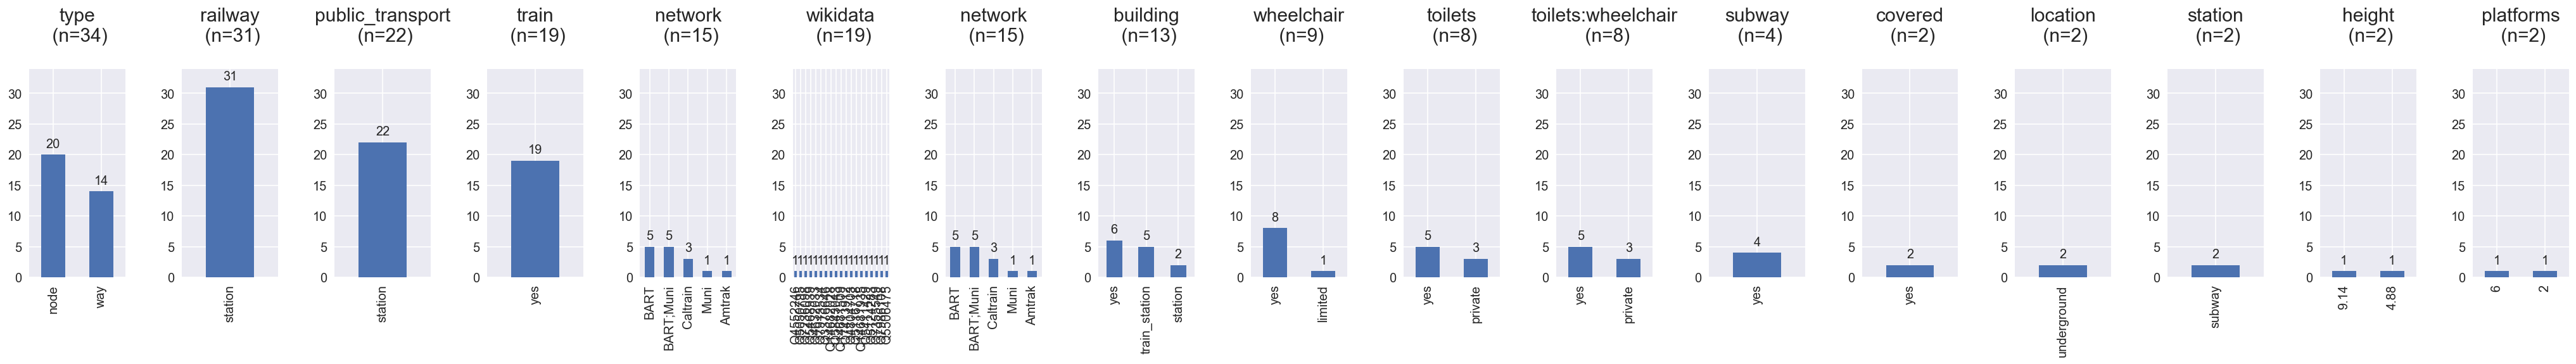

In [360]:
station_tag_hist = make_many_histograms(station_keys_to_plot, station_key_value_pairs, station_key_counts, suptitle="OSM Station Tags by Frequency in SF and Oakland")
station_tag_hist.savefig('images/station_tags.png')

# Analyze OSM Egress tags

In [316]:
egresses_in_bbox = get_egresses_in_bbox(bbox)
geojson2leaflet(egresses_in_bbox)

82 points of interest returned.
1 as ways and 81 as nodes.


### Count Egress Tag Keys

In [317]:
egress_key_counts = tag_key_counter(egresses_in_bbox)

82 total records.
1 as ways, 81 as nodes


In [318]:
most_popular_egress_keys = get_most_popular_tag_keys(egress_key_counts)
most_popular_egress_keys.head(20)

,Count,Percent
@id,82,100.000000
id,82,100.000000
railway,82,100.000000
type,82,100.000000
wheelchair,45,54.878049
ref,33,40.243902
name,27,32.926829
operator,20,24.390244
network,19,23.170732
station_name,19,23.170732


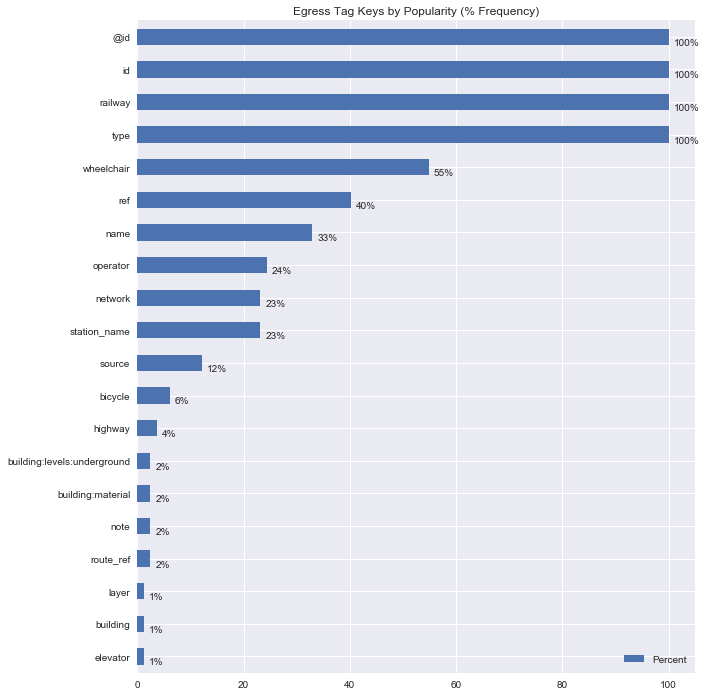

In [319]:
plot_most_popular_tag_keys(most_popular_egress_keys, title="Egress Tag Keys by Popularity (% Frequency)")

In [320]:
egress_key_value_pairs = get_tag_key_value_pairs(egresses_in_bbox)

In [321]:
egress_key_value_pairs_df = make_key_value_df(egress_key_value_pairs, egresses_in_bbox, most_popular_egress_keys)
egress_key_value_pairs_df

,Market & Sutter St,19th Street BART Street Elevator,Market & 5th St,Market Street,Market & Leavenworth Streets,Market & Ellis St,Market & 4th St / Moscone Center,Lake Merritt,UN Plaza,Lake Merritt,Market & 4th St,Market & 8th Street,Market & 5th St,Market & 7th Streets,Market St (500 Block),Market & 5th St,Market & Montgomery St,Lake Merritt,Sansome & Sutter St,Market & 8th Streets,Market & 2nd St,Market & Hyde Streets,Oakland City Center - 12th Street,Market & Post St,Oakland City Center - 12th Street,Market & Grove Streets,Lake Merritt
@id,node/2068535617,node/4194436461,node/532798624,node/815235101,node/1420265758,node/1677844643,node/1677844648,node/1325354935,node/411095082,node/1325354935,node/1677844661,node/376214199,node/532798624,node/1420265514,node/1677860415,node/532798624,node/1677860418,node/1325354935,node/3078438194,node/307639379,node/1677860436,node/307639383,node/1378045543,node/386569186,node/1378045543,node/307639406,node/1325354935
id,2068535617,4194436461,532798624,815235101,1420265758,1677844643,1677844648,1325354935,411095082,1325354935,1677844661,376214199,532798624,1420265514,1677860415,532798624,1677860418,1325354935,3078438194,307639379,1677860436,307639383,1378045543,386569186,1378045543,307639406,1325354935
railway,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance,subway_entrance
type,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node
wheelchair,,yes,yes,,no,yes,yes,no,no,no,yes,,yes,no,no,yes,no,no,,,no,,no,,no,,no
ref,A3,,B1,B3,A4,A2,B4,,A3,,B3,B1,B1,B4,B3,B1,A2,,A4,B2,B2,A2,,A1,,A1,
name,Market & Sutter St,19th Street BART Street Elevator,Market & 5th St,Market Street,Market & Leavenworth Streets,Market & Ellis St,Market & 4th St / Moscone Center,Lake Merritt,UN Plaza,Lake Merritt,Market & 4th St,Market & 8th Street,Market & 5th St,Market & 7th Streets,Market St (500 Block),Market & 5th St,Market & Montgomery St,Lake Merritt,Sansome & Sutter St,Market & 8th Streets,Market & 2nd St,Market & Hyde Streets,Oakland City Center - 12th Street,Market & Post St,Oakland City Center - 12th Street,Market & Grove Streets,Lake Merritt
operator,,,,BART;Muni,,,,,BART;Muni,,,,,,,,,,BART;Muni,,,,,BART;Muni,,,
network,,,BART;Muni,BART;Muni,BART;Muni,,,,BART;Muni,,,BART;Muni,BART;Muni,BART;Muni,,BART;Muni,,,,BART;Muni,,BART;Muni,,BART;Muni,,BART;Muni,
station_name,,,,Civic Center Station,,,,,Civic Center Station,,,,,,,,,,Montgomery Station,,,,,Montgomery Station,,,


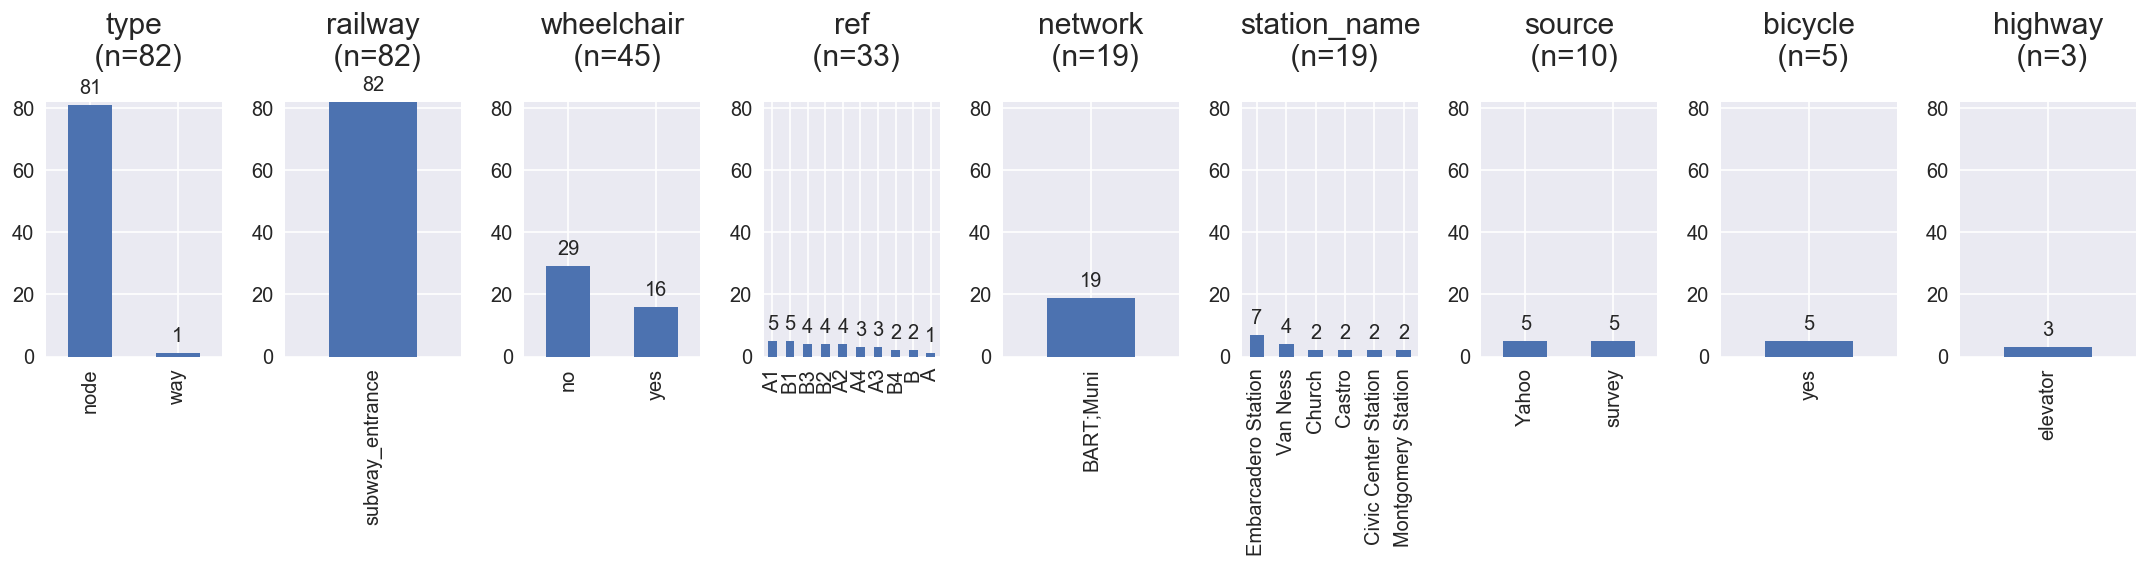

In [363]:
egress_keys_to_plot = ['type', 'railway', 'wheelchair', 'ref', 'network', 'station_name', 'source', 'bicycle','highway']
egress_tag_hist = make_many_histograms(egress_keys_to_plot, egress_key_value_pairs, egress_key_counts, suptitle="OSM Egress Tags by Frequency in SF and Oakland")
egress_tag_hist.savefig('images/egress_tags.png')

# Analyze OSM Platform tags

In [323]:
platforms_in_bbox = get_platforms_in_bbox(bbox)
geojson2leaflet(platforms_in_bbox)

196 points of interest returned.
133 as ways and 63 as nodes.


### Count Platform Tag Keys

In [324]:
platform_key_counts = tag_key_counter(platforms_in_bbox)

196 total records.
133 as ways, 63 as nodes


In [325]:
most_popular_platform_keys = get_most_popular_tag_keys(platform_key_counts)
most_popular_platform_keys.head(20)

,Count,Percent
type,196,100.000000
id,196,100.000000
@id,196,100.000000
railway,131,66.836735
public_transport,97,49.489796
name,66,33.673469
ref,58,29.591837
bus,57,29.081633
highway,51,26.020408
operator,32,16.326531


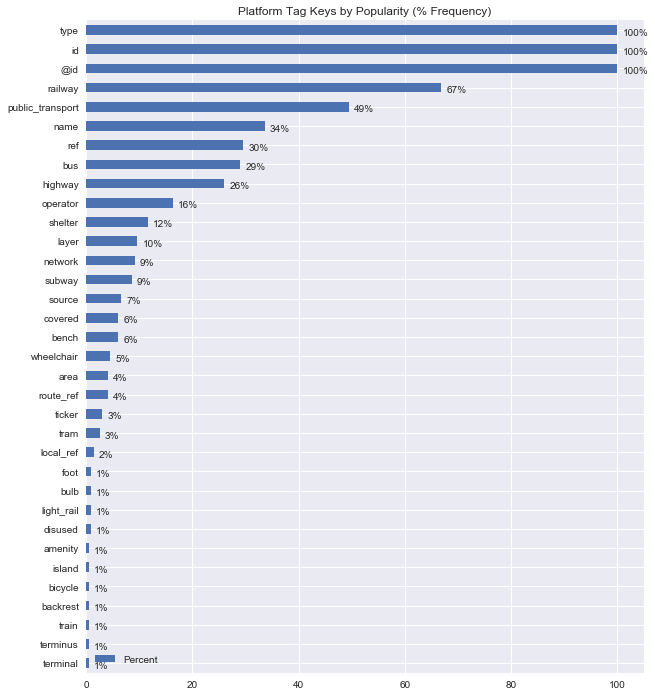

In [326]:
plot_most_popular_tag_keys(most_popular_platform_keys, title="Platform Tag Keys by Popularity (% Frequency)")

In [327]:
platform_key_value_pairs = get_tag_key_value_pairs(platforms_in_bbox)

In [328]:
platform_key_value_pairs_df = make_key_value_df(platform_key_value_pairs, platforms_in_bbox, most_popular_platform_keys)
platform_key_value_pairs_df

,Platform 3,Platform 1,Platform 2,Platform 1,Platform 2,Track 2,Track 4,Track 6,Track 8,Track 10,Track 12,Platform 1,Track 11,Track 9,Track 7,Track 5,Track 3,Track 1,Platform 3,Platform 1,Platform 1,Platform 2,Platform 2,17th St & Castro St,Platform 2,Platform 1,Platform 1,Platform 2,Platform 2,Platform 2,Platform 1,Platform 2,Platform 1,Platform 2,Platform 1,Platform 2,Platform 1,Telegraph Av & Stuart St,Transbay Terminal,Church & Doboce,College Av & Chabot Av,College Av & Alcatraz Av,College Av & Alcatraz Av,College Av & Ashby Av,College Av & Ashby Av,College Av & Chabot Av,College Av & Claremont Av,College Av & Claremont Av,College Av & Woolsey St,College Av & Miles Av (Claremont Middle School),Telegraph Av & Stuart St,College Av & Rock Ridge BART Station,College Av & Russell St,College Av & Russell St,College Av & Webster St,College Av & Webster St,College Av & Woolsey St,Miles Av & College Av,Powell,Telegraph Av & Derby St,Transbay Terminal,Dwight Cresent & 7th St,The Jolly Trolly,Kansas Street & 23rd Street,Jones & Beach Street,College Av & Oak Grove Av (Opp. Claremont)
type,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,way,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node,node
id,104453095,370555338,370555337,370555338,370555337,346766963,346766964,346766965,346766967,346766968,346766969,370555338,61555848,61555859,61555863,61555889,61555893,61555898,104453095,370555338,370555338,370555337,370555337,67591080,370555337,370555338,370555338,370555337,370555337,370555337,370555338,370555337,370555338,370555337,370555338,370555337,370555338,2062592938,1855979993,1241518350,2062580257,2062580253,2062580253,2062580255,2062580255,2062580257,2062580259,2062580259,2062580274,2062580264,2062592938,2062580268,2062580270,2062580270,2062580272,2062580272,2062580274,2062580275,3396505661,2062592930,1855979993,2060883684,4438563335,3924068520,3102341569,2062580265
@id,way/104453095,way/370555338,way/370555337,way/370555338,way/370555337,way/346766963,way/346766964,way/346766965,way/346766967,way/346766968,way/346766969,way/370555338,way/61555848,way/61555859,way/61555863,way/61555889,way/61555893,way/61555898,way/104453095,way/370555338,way/370555338,way/370555337,way/370555337,way/67591080,way/370555337,way/370555338,way/370555338,way/370555337,way/370555337,way/370555337,way/370555338,way/370555337,way/370555338,way/370555337,way/370555338,way/370555337,way/370555338,node/2062592938,node/1855979993,node/1241518350,node/2062580257,node/2062580253,node/2062580253,node/2062580255,node/2062580255,node/2062580257,node/2062580259,node/2062580259,node/2062580274,node/2062580264,node/2062592938,node/2062580268,node/2062580270,node/2062580270,node/2062580272,node/2062580272,node/2062580274,node/2062580275,node/3396505661,node/2062592930,node/1855979993,node/2060883684,node/4438563335,node/3924068520,node/3102341569,node/2062580265
railway,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,,,,,,,,,,,,,,,,,,,,,,platform,,,,platform,,tram_stop,
public_transport,,platform,platform,platform,platform,,,,,,,platform,,,,,,,,platform,platform,platform,platform,,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,platform,,platform,platform,platform
name,Platform 3,Platform 1,Platform 2,Platform 1,Platform 2,Track 2

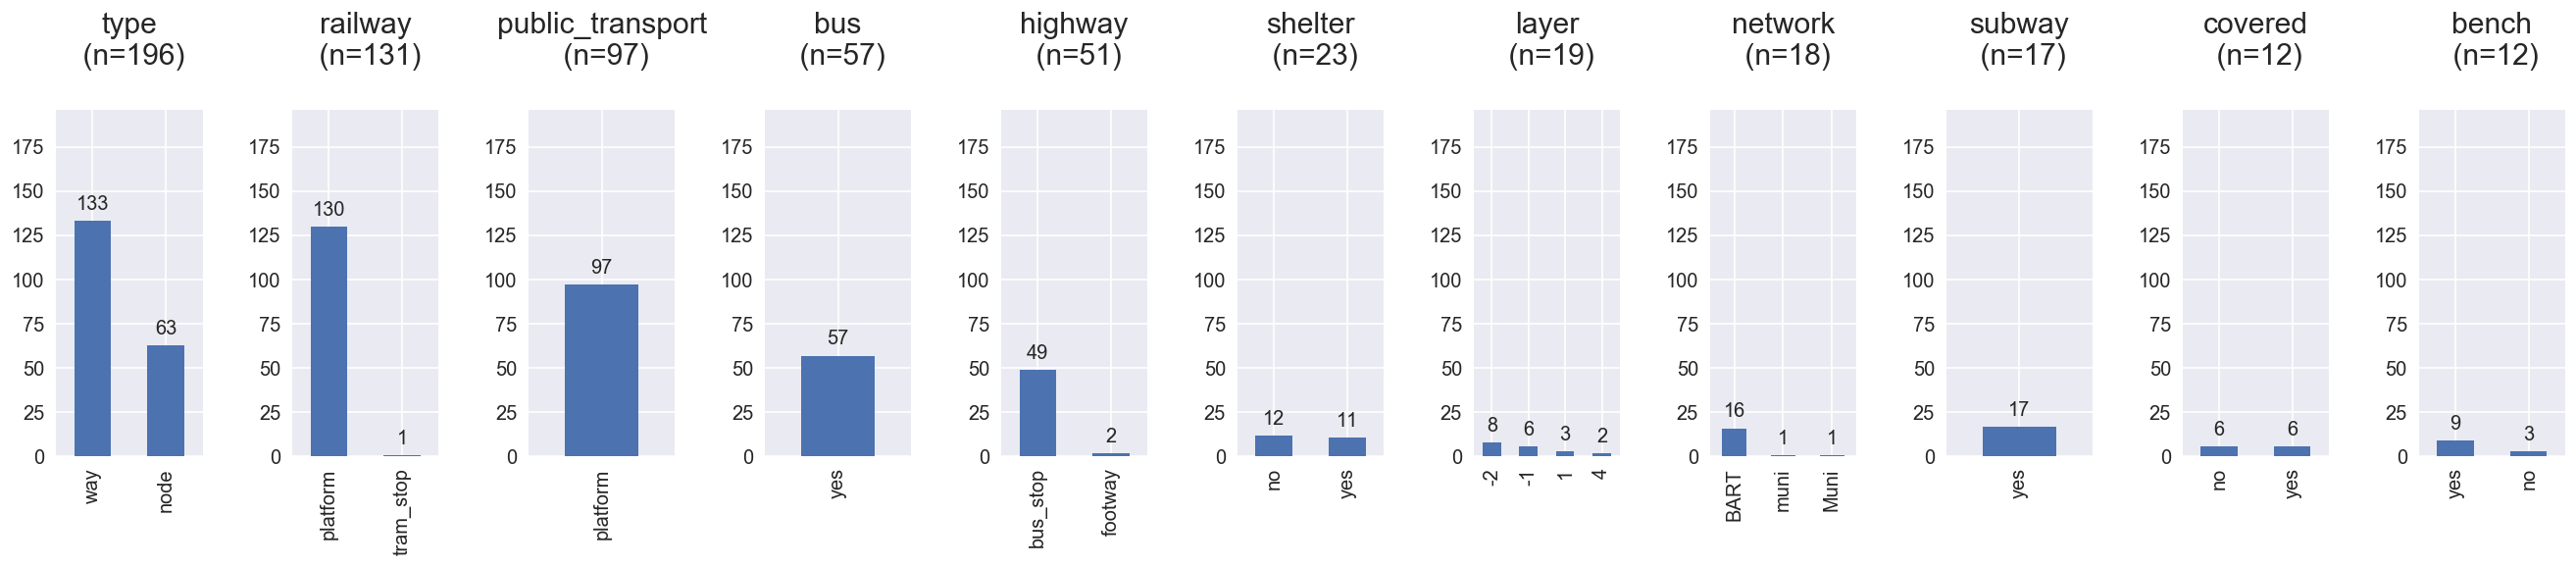

In [364]:
platform_keys_to_plot = ['type', 'railway', 'public_transport', 'bus', 'highway', 'shelter', 'layer','network', 'subway', 'covered', 'bench']
platform_tag_hist = make_many_histograms(platform_keys_to_plot, platform_key_value_pairs, platform_key_counts, suptitle="OSM Platform Tags by Frequency in SF and Oakland")
platform_tag_hist.savefig('images/platform_tags.png')

# Analyze OSM Bus Stop tags

In [ ]:
bus_stops_in_bbox = get_bus_stops_in_bbox(bbox)
geojson2leaflet(bus_stops_in_bbox)

### Count Bus Stop Tag Keys

In [331]:
bus_stop_key_counts = tag_key_counter(bus_stops_in_bbox)

1241 total records.
0 as ways, 1241 as nodes


In [332]:
most_popular_bus_stop_keys = get_most_popular_tag_keys(bus_stop_key_counts)
most_popular_bus_stop_keys.head(20)

,Count,Percent
type,1241,100.000000
@id,1241,100.000000
highway,1241,100.000000
id,1241,100.000000
operator,817,65.834005
shelter,743,59.871072
route_ref,660,53.182917
source,584,47.058824
ticker,583,46.978243
bulb,289,23.287671


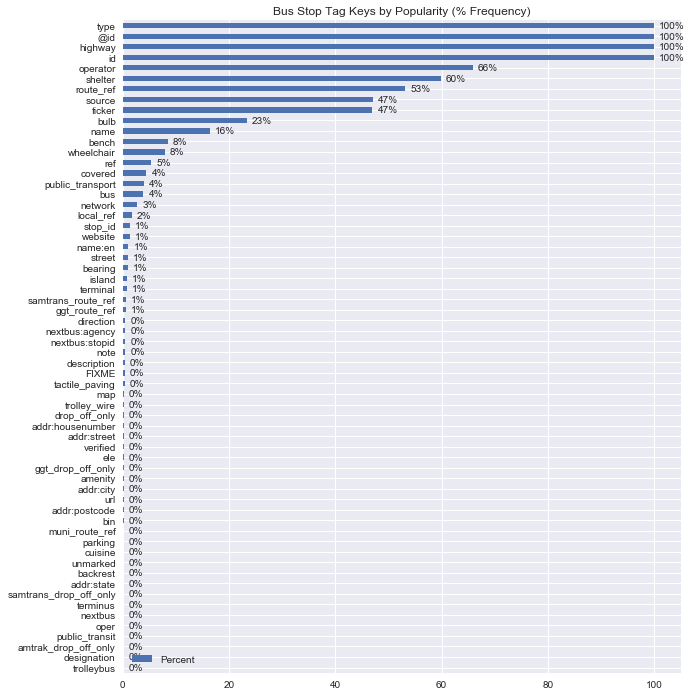

In [333]:
plot_most_popular_tag_keys(most_popular_bus_stop_keys, title="Bus Stop Tag Keys by Popularity (% Frequency)")

In [334]:
bus_stop_key_value_pairs = get_tag_key_value_pairs(bus_stops_in_bbox)

In [335]:
bus_stop_key_value_pairs_df = make_key_value_df(bus_stop_key_value_pairs, bus_stops_in_bbox, most_popular_bus_stop_keys)
bus_stop_key_value_pairs_df

,Park Blvd & Trestle Glen Rd,11th & H Ave,Park Blvd & Glen Park Rd,Spencer Ave Bus Pad,Terminal Line O Transbay,Chestnut & Pierce,Transbay Terminal,24th St & Guerrero St,Park Blvd & Dolores Ave,Sacramento St & Sansome St,Fruitvale & MacArthur,Clay St & Drumm St,24th St & Valencia St,Sacramento St & Montgomery St,Clay St & Kearny St,4th St & Townsend St,Sacramento St & Battery St,A,Market St and Noe St,8th Avenue,6th Avenue,8th Avenue,8th Avenue,17th Street,Market St & Noe St,Dwight Cresent & 7th St,muni,13th Street,Sacramento St & Cherry St (Stop 16293),19,MUNI 10 Townsend Route,Transbay Terminal,Transbay Terminal,"Big Bus Tours Stop 10, Haight Ashbury",Transbay Terminal,Transbay Terminal,Transbay Terminal,Transbay Terminal,MacArthur at Fruitvale,Line OX TransBay,Transbay Terminal,City Center,Transbay Terminal,"Big Bus Tours Stop 17, China Town",Market St & Van Ness Ave,San Francisco Megabus,59th Street,"Big Bus Tours Stop 4, Embarcadero",College Av & Alcatraz Av,College Av & Alcatraz Av,College Av & Chabot Av,College Av & Chabot Av,"Big Bus Tours Stop 6, Hilton Hotel",19,College Av & Russell St,College Av & Russell St,College Av & Webster St,College Av & Webster St,College Av & Woolsey St,Sansome St & Clay St,Park Blvd & Everett Ave,16th Street & Rhode Island,51A South,Transbay Terminal,MacArthur at Fruitvale,18th St. & Hattie St.,"Big Bus Tours Stop 22, Downtown Sausalito","Big Bus Tours Stop 8, Fulton Street","Big Bus Tours Stop 9, Alamo Square",Transbay Terminal,24 Inbound,26th St and Noe St,Masonic St & Frederick St,Frederick St & Masonic St,59th Street,26th St and Noe St,F,24th St & Guerrero St,Transbay Terminal,Bridgeway & Turney St,"Big Bus Tours Stop 1, Fisherman's Visitor Center","Big Bus Tours Stop 11, Golden Gate Park","Big Bus Tours Stop 13, Palace of Fine Arts","Big Bus Tours Stop 14, Lombard Street 1","Big Bus Tours Stop 18, Steuart Street","Big Bus Tours Stop 19, Pier 39","Big Bus Tours Stop 2, Activity Center","Big Bus Tours Stop 3, Washington Square",B,"Big Bus Tours Stop 5, Union Square South","Big Bus Tours Stop 7, Civic Center",Molimo Drive,muni,24th St & Dolores St,muni,17th St & Diamond St,Bayside,Spencer Ave Bus Pad,D,College Av & Oak Grove Av (Opp. Claremont),E,14th St & Church St,muni,14th St & Church St,Market St & Church St,Mason,Church St & Market St,Telegraph Av & Stuart St,Telegraph Av & Stuart St,"1, 1AX",Transbay Terminal,Transbay Terminal,Main Gate,Main Gate,9th & H Ave,Gateview,Northpoint Drive,"Big Bus Tours Stop 12, Golden Gate Bridge North",Fruitvale at MacArthur,Transbay Terminal,7th St,Fruitvale & Montana,9th & Avenue B,"Big Bus Tours Stop 15, Lombard Street 2",Transbay Terminal,Haight St & Buchanan St,19,24th St & Dolores St,1 California OB (Sacramento/Larkin),Bay St & Bridgeway,College Av & Ashby Av,College Av & Ashby Av,MacArthur at Canon,Rhode Island & 23rd Street,College Av & Claremont Av,"43, 37",MacArthur at Canon,Harrison St,College Av & Miles Av (Claremont Middle School),19,College Av & Rock Ridge BART Station,Bridgeway & Pine St,Bridgeway & Caledonia St,Bridgeway & Bay St,College Av & Woolsey St,Veterans Memorial,Market St & Church St,19th Street,Castro St and 25th St,19 Inbound to Fisherman's Wharf,24th St & Valencia St,Division St & Camden St,Townsend St & 5th St,51A North,Bridgeway & Napa St,19,Park Blvd & Glenfield Ave,Market St & South Van Ness Ave,Telegraph Av & Derby St,Miles Av & College Av,Avenue B,"Big Bus Tours Stop 2 (Panoramic Night Tour), Treasure Island",Aldea Shuttle,Haight St & Buchanan St,Haight St & Laguna St,Laguna St & Haight St,Southern Heights,Castro St & 17th St,Castro St & 17th St,Market St & 17th St,Market St & Castro St,Castro St and 25th St,"Big Bus Tours Stop 16, Union Square North",Britton Street,Britton Street,Adeline St:14th St,Park Blvd & Dolores Ave,Molimo Drive,Sansome St & California St,Clay St & Sansome St,Sansome St & Sacramento St,Clay St & Montgomery St,Clay St & Front St,Kearny St & Clay St,Sacramento St & Davis St,Columbus Ave & Washing

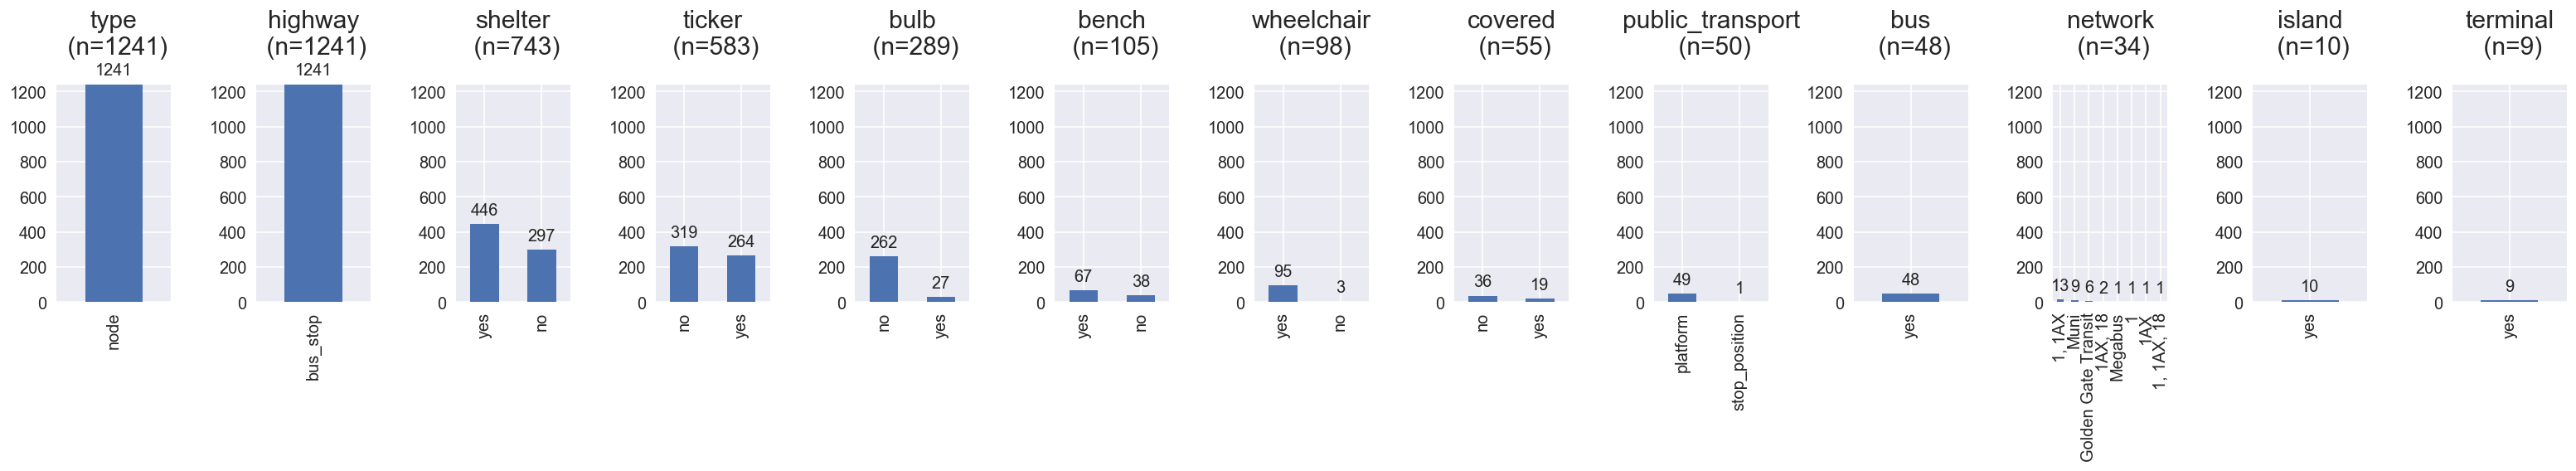

In [354]:
bus_stop_keys_to_plot = ['type', 'highway', 'shelter', 'ticker', 'bulb', 'bench', 'wheelchair', 'covered', 'public_transport', 'bus', 'network', 'island', 'terminal']
bus_stop_tag_hist = make_many_histograms(bus_stop_keys_to_plot, bus_stop_key_value_pairs, bus_stop_key_counts, suptitle="OSM Bus Stop Tags by Frequency in SF and Oakland")
bus_stop_tag_hist.savefig('images/bus_stop_tags.png')

# Random notes...

Here's a custom overpass -> geojson function without the dependency on external geojson library:

In [35]:
def overpass2geojson_standalone(data):
    ways = [i for i in data["elements"] if i["type"] == "way"]
    nodes = [i for i in data["elements"] if i["type"] == "node"]
    
    # Create reference dicts for quick lookups
    lookup_wayid = {}
    lookup_nodeid = {}
        
    for i in nodes:
        lookup_nodeid[i["id"]] = [i["lon"], i["lat"]]
        
    for i in ways:
        lookup_wayid[i["id"]] = i
        
        lookup_wayid[i["id"]]["geometry"] = {
            "coordinates": [[lookup_nodeid[j] for j in i["nodes"]]],
            "type": "Polygon"
        }
        lookup_wayid[i["id"]]["properties"] = lookup_wayid[i["id"]]["tags"]
        
    # Write geojson
    geojson_output = {
      "type": "FeatureCollection",
      "generator": "overpass-ide",
      "copyright": "The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.",
      "features": []
    }
    
    for i in lookup_wayid.keys():
        geo_feature = {
          "type": "Feature",
          "properties": lookup_wayid[i]["tags"],
          "geometry": lookup_wayid[i]["geometry"],
          "id": i        
        }
        geojson_output["features"].append(geo_feature)
        
    return geojson_output

In [ ]:
m = folium.Map(location=[37.8, -122.3], zoom_start=12)
folium.GeoJson(geojson).add_to(m)
m

In [ ]:
def overpass2leaflet(overpass_json, zoom_start=11, tiles="OpenStreetMap"):

    overpass_geojson = overpass2geojson(overpass_json)
    
    try:
        centerLat = overpass_json['elements'][0]['lat']
        centerLon = overpass_json['elements'][0]['lon']
    except:
        centerLat = overpass_json['elements'][-1]['lat']
        centerLon = overpass_json['elements'][-1]['lon']
    
    m = folium.Map(location=[centerLat, centerLon], zoom_start=zoom_start, tiles=tiles)        
    gj = folium.GeoJson(overpass_geojson)
    gj.add_to(m)

    return m

In [ ]:
def get_stations_near_way_id(osm_way_id, radius=50):
    '''Returns station ways and nodes with radius to a specified OSM way id'''
    
    base_url = "https://overpass-api.de/api/interpreter?data="

    query = """
    [out:json][timeout:500];

    way(id:{0})->.target;

    (    
      // Get ways near way target
      way(around.target:{1})["railway"="station"];
      way(around.target:{1})["public_transport"="station"];
      way(around.target:{1})["building"="train_station"];
      
      // Get nodes near node target
      node(around.target:{1})["railway"="station"]["usage" != "tourism"];
      node(around.target:{1})["public_transport"="station"];
      node(around.target:{1})["building"="train_station"];
    );

    out body;
    >;
    out skel qt;
    """.format(osm_way_id, radius)

    query_htmlified = urllib.quote(query.strip())
    api_request = base_url + query_htmlified
    response = requests.get(api_request)
    data = response.json()
    geojson = overpass2geojson(data)
    
    return geojson

stations_near_way_id = get_stations_near_way_id(286685354)

geojson2leaflet(stations_near_way_id, zoom_start=17)